In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from sklearn.linear_model import Ridge

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

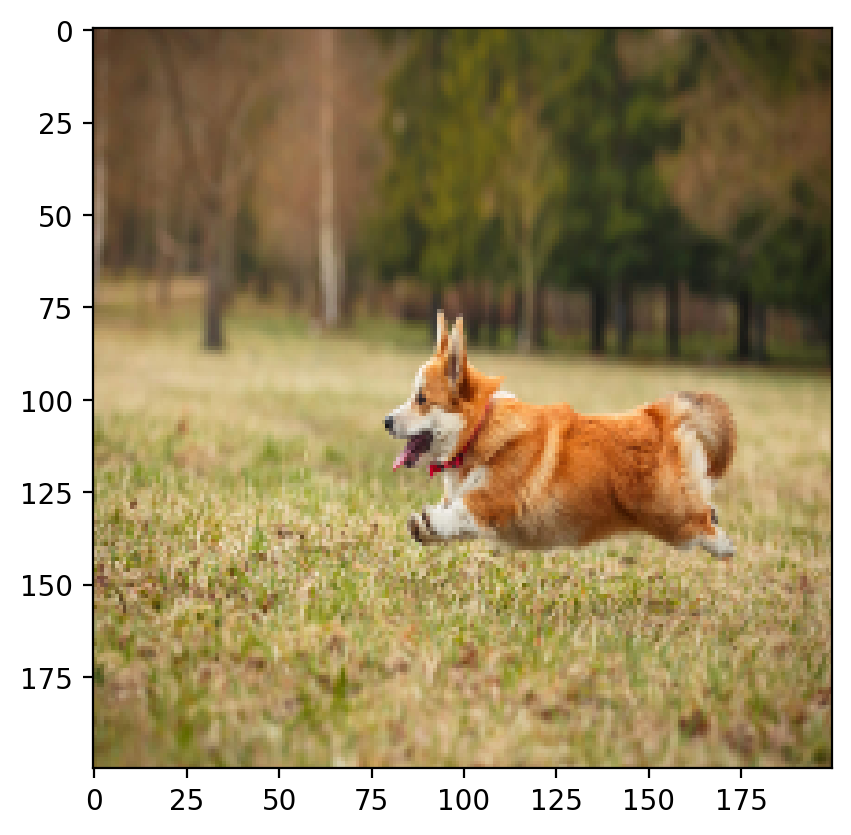

In [47]:
# Load high-resolution image
original_image = cv2.imread('dog.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

high_res_image = cv2.resize(original_image, (400, 400))

# Downscale to 200x200 to simulate a low-resolution image
low_res_image = cv2.resize(high_res_image, (200, 200))

plt.imshow(low_res_image)

In [33]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2)) #Creating random fourier features
    X = X.cpu().numpy() #Converting to numpy array
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

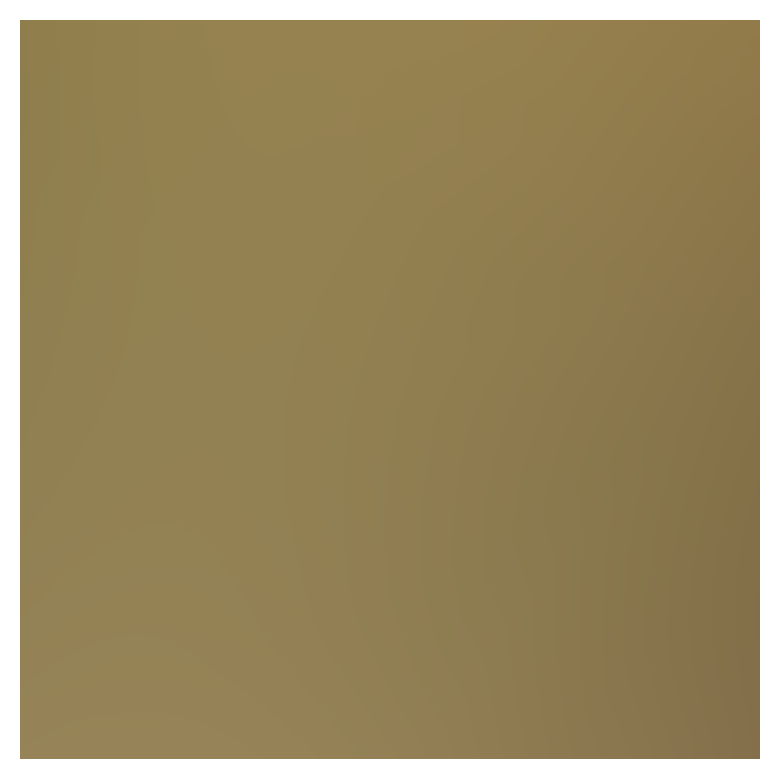

In [50]:
# Flatten the low-resolution image to shape (n_samples, 3)
low_res_image_flat = low_res_image.reshape(-1, 3)  # Shape will be (40000, 3) for a 200x200 image

D = 4000  # Dimension of the Fourier features
Z_low_res = create_rff_features(torch.tensor(low_res_image_flat, dtype=torch.float32).to(device), D, 0.008)

# Train a linear regression model for each channel (RGB)
models = []
for channel in range(3):
    model = Ridge(alpha=1.0)  # Regularized regression (Ridge)
    model.fit(Z_low_res.cpu().numpy(), low_res_image_flat[:, channel])  # Move to CPU for fitting
    models.append(model)

# Generate RFF features for the high-res grid
x, y = np.meshgrid(np.linspace(0, 1, 400), np.linspace(0, 1, 400))
coords_high_res = np.vstack([x.ravel(), y.ravel()]).T  # Shape (160000, 2)

# Ensure omega is generated properly
omega = np.random.randn(D, 2)  # Shape (D, 2)

# Calculate Z_high_res
Z_high_res = np.sqrt(2.0 / D) * np.cos(coords_high_res @ omega.T + 2 * np.pi * np.random.rand(D))

# Predict pixel values for the high-res image
predicted_high_res = np.zeros((400 * 400, 3))
for channel in range(3):
    predicted_high_res[:, channel] = models[channel].predict(Z_high_res)

# Reshape the prediction back into an image
predicted_high_res_image = predicted_high_res.reshape(400, 400, 3).astype(np.uint8)

# Example visualization
plt.imshow(predicted_high_res_image)
plt.axis('off')
plt.show()